# Embedding Model Comparison: How Topics Cluster Differently 🎯

This notebook demonstrates how different embedding models create different vector representations for the same text, leading to different semantic clustering patterns.

## What We'll Explore:
- 🤖 **OpenAI** vs **HuggingFace** embedders
- 📊 Visualizing topic clusters in 2D space
- 🔍 Analyzing similarity scores between topics
- 🎨 Interactive plots showing clustering differences

## Key Learning: 
Different embedders have different "opinions" about what topics are similar!


In [4]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Import embedders (using existing workshop infrastructure)
import sys
sys.path.append('../module-2')
from utility_2 import do_get_embedder

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


## 📝 Define Our Test Topics

We'll use diverse topics to see how different embedders cluster them:


In [5]:
# Define test topics across different domains
topics = {
    # Technology
    "Artificial Intelligence": "Machine learning algorithms that can learn and make decisions like humans",
    "Machine Learning": "Computer systems that automatically improve through experience using data",
    "Deep Learning": "Neural networks with multiple layers that can learn complex patterns",
    "Data Science": "Extracting insights and knowledge from structured and unstructured data",
    "Programming": "Writing instructions for computers to execute specific tasks",
    "Software Engineering": "Systematic approach to designing and building software applications",
    
    # Science
    "Physics": "Study of matter, energy, and their interactions in the universe",
    "Chemistry": "Science of atoms, molecules, and chemical reactions",
    "Biology": "Study of living organisms and their life processes",
    "Mathematics": "Abstract science of numbers, quantity, structure, and space",
    
    # Arts & Culture
    "Painting": "Visual art using pigments and brushes to create images on canvas",
    "Music": "Art form using sound, rhythm, and melody to express emotions",
    "Literature": "Written works including novels, poetry, and plays",
    "Theater": "Performing art involving actors presenting stories on stage",
    
    # Sports
    "Football": "Team sport played with oval ball and goal posts",
    "Basketball": "Team sport where players score by shooting ball through hoops",
    "Tennis": "Racket sport played on a court with a net",
    "Swimming": "Sport of moving through water using various stroke techniques",
    
    # Food
    "Italian Cuisine": "Traditional cooking from Italy featuring pasta, pizza, and regional dishes",
    "Japanese Cuisine": "Traditional Japanese cooking including sushi, ramen, and seasonal ingredients",
    "Baking": "Cooking method using dry heat to make bread, cakes, and pastries",
    "Vegetarian Cooking": "Food preparation without meat, focusing on plant-based ingredients"
}

topic_names = list(topics.keys())
topic_descriptions = list(topics.values())

print(f"📋 Defined {len(topics)} topics across multiple domains:")
for i, (name, desc) in enumerate(topics.items()):
    print(f"{i+1:2d}. {name}")


📋 Defined 22 topics across multiple domains:
 1. Artificial Intelligence
 2. Machine Learning
 3. Deep Learning
 4. Data Science
 5. Programming
 6. Software Engineering
 7. Physics
 8. Chemistry
 9. Biology
10. Mathematics
11. Painting
12. Music
13. Literature
14. Theater
15. Football
16. Basketball
17. Tennis
18. Swimming
19. Italian Cuisine
20. Japanese Cuisine
21. Baking
22. Vegetarian Cooking


## 🤖 Initialize Embedders

Let's set up our two different embedding models:


In [6]:
def do_initialize_embedders():
    """Initialize both OpenAI and HuggingFace embedders."""
    embedders = {}
    
    # Try OpenAI embedder
    try:
        embedders['OpenAI'] = do_get_embedder('openai')
        print("✅ OpenAI embedder initialized")
    except Exception as e:
        print(f"⚠️  OpenAI embedder failed: {e}")
        print("💡 Make sure OPENAI_API_KEY is set in your environment")
    
    # Try HuggingFace embedder (usually works without API key)
    try:
        embedders['HuggingFace'] = do_get_embedder('huggingface')
        print("✅ HuggingFace embedder initialized")
    except Exception as e:
        print(f"⚠️  HuggingFace embedder failed: {e}")
        print("💡 Try: pip install langchain-huggingface sentence-transformers")
    
    return embedders

embedders = do_initialize_embedders()


✅ OpenAI embedder initialized
✅ HuggingFace embedder initialized


## 🎯 Generate Embeddings

Now let's create vector embeddings for all our topics using both models:


In [7]:
def do_generate_embeddings(embedders, texts):
    """Generate embeddings for all texts using all available embedders."""
    embeddings_data = {}
    
    for embedder_name, embedder in embedders.items():
        print(f"🔄 Generating embeddings with {embedder_name}...")
        try:
            # Get embeddings for all texts
            vectors = embedder.embed_documents(texts)
            embeddings_data[embedder_name] = np.array(vectors)
            print(f"✅ {embedder_name}: {len(vectors)} embeddings of dimension {len(vectors[0])}")
        except Exception as e:
            print(f"❌ {embedder_name} failed: {e}")
            continue
    
    return embeddings_data

# Generate embeddings using topic descriptions
embeddings_data = do_generate_embeddings(embedders, topic_descriptions)

print(f"\n📊 Generated embeddings for {len(embeddings_data)} models")


🔄 Generating embeddings with OpenAI...
✅ OpenAI: 22 embeddings of dimension 1536
🔄 Generating embeddings with HuggingFace...
✅ HuggingFace: 22 embeddings of dimension 384

📊 Generated embeddings for 2 models


## 📈 Calculate Similarity Matrices

Let's see how similar each topic is to every other topic according to each embedder:


In [8]:
def do_calculate_similarity_matrices(embeddings_data, topic_names):
    """Calculate cosine similarity matrices for each embedder."""
    similarity_matrices = {}
    
    for embedder_name, embeddings in embeddings_data.items():
        # Calculate cosine similarity
        similarity_matrix = cosine_similarity(embeddings)
        
        # Convert to DataFrame for easier handling
        similarity_df = pd.DataFrame(
            similarity_matrix, 
            index=topic_names, 
            columns=topic_names
        )
        
        similarity_matrices[embedder_name] = similarity_df
        
        print(f"📊 {embedder_name} similarity matrix: {similarity_matrix.shape}")
    
    return similarity_matrices

similarity_matrices = do_calculate_similarity_matrices(embeddings_data, topic_names)


📊 OpenAI similarity matrix: (22, 22)
📊 HuggingFace similarity matrix: (22, 22)


## 🎨 Visualize Similarity Heatmaps

Let's create side-by-side heatmaps to compare how each embedder sees topic relationships:


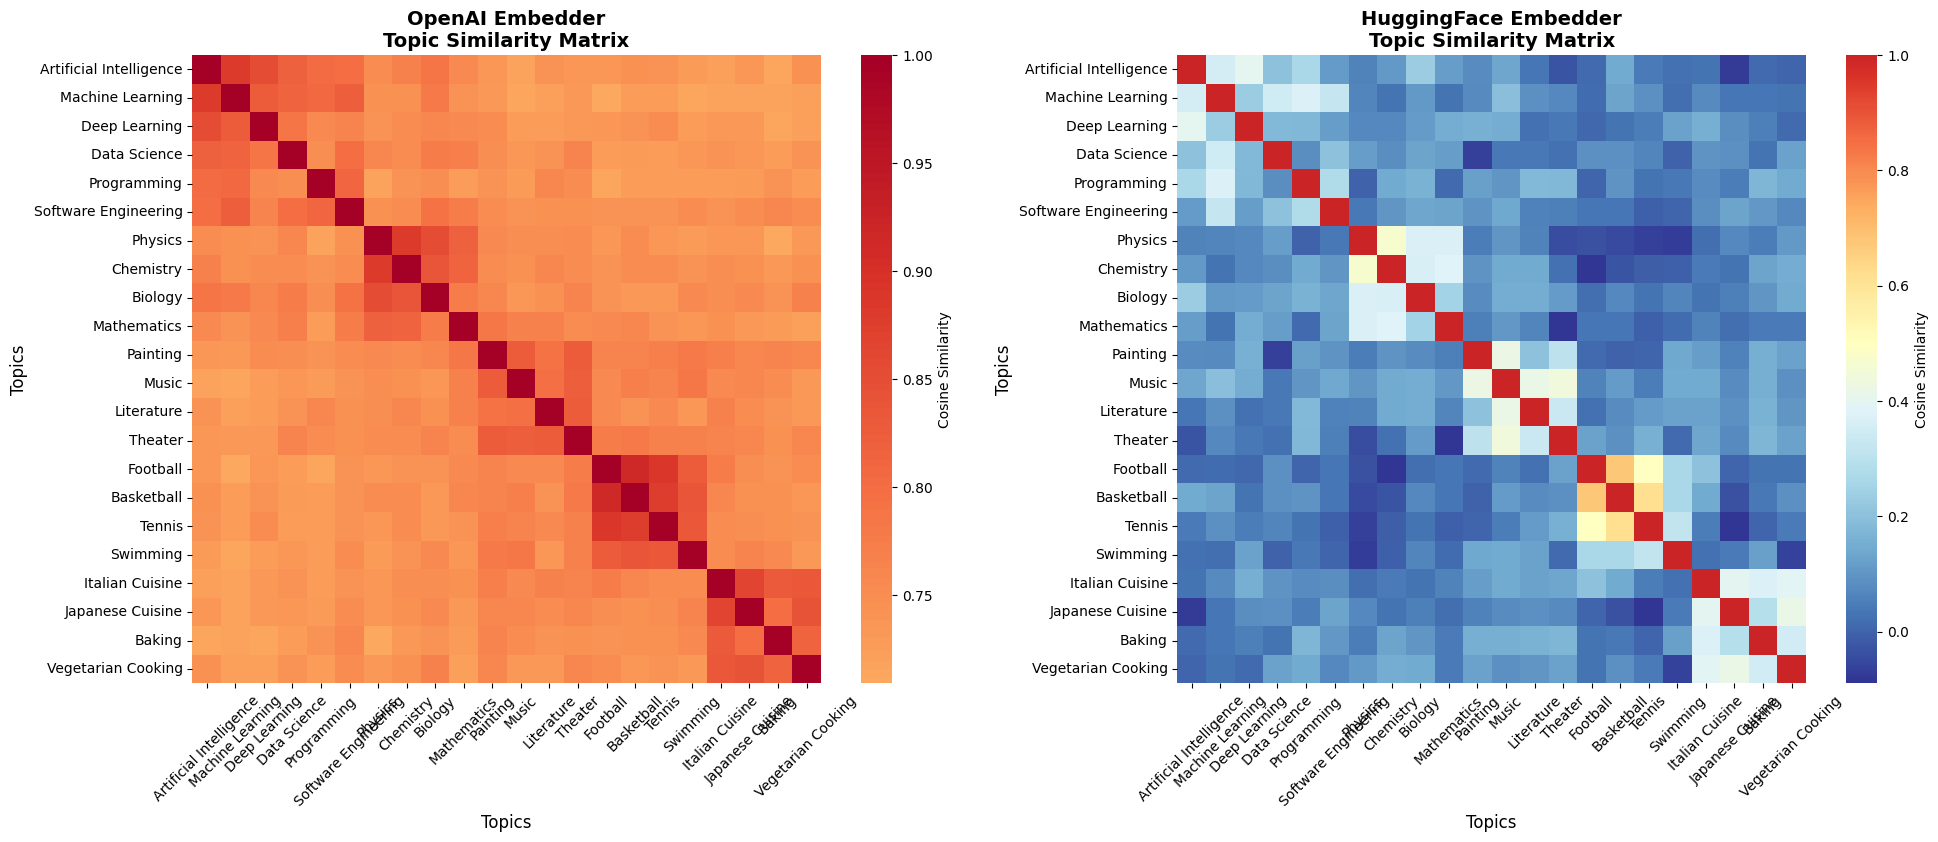

In [9]:
def do_plot_similarity_heatmaps(similarity_matrices):
    """Create side-by-side heatmaps showing similarity matrices."""
    embedder_names = list(similarity_matrices.keys())
    
    if len(embedder_names) < 2:
        print("⚠️  Need at least 2 embedders for comparison")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    for i, embedder_name in enumerate(embedder_names[:2]):
        similarity_df = similarity_matrices[embedder_name]
        
        # Create heatmap
        sns.heatmap(
            similarity_df, 
            annot=False, 
            cmap='RdYlBu_r', 
            center=0.5,
            square=True,
            ax=axes[i],
            cbar_kws={'label': 'Cosine Similarity'}
        )
        
        axes[i].set_title(f'{embedder_name} Embedder\nTopic Similarity Matrix', 
                         fontsize=14, fontweight='bold')
        axes[i].set_xlabel('Topics', fontsize=12)
        axes[i].set_ylabel('Topics', fontsize=12)
        
        # Rotate labels for better readability
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].tick_params(axis='y', rotation=0)
    
    plt.tight_layout()
    plt.show()

do_plot_similarity_heatmaps(similarity_matrices)


## 🔍 Find Most Different Similarity Pairs

Let's identify which topic pairs have the most different similarity scores between embedders:


In [10]:
def do_find_similarity_differences(similarity_matrices):
    """Find topic pairs with biggest similarity differences between embedders."""
    embedder_names = list(similarity_matrices.keys())
    
    if len(embedder_names) < 2:
        print("⚠️  Need at least 2 embedders for comparison")
        return
    
    # Get the two similarity matrices
    sim1 = similarity_matrices[embedder_names[0]]
    sim2 = similarity_matrices[embedder_names[1]]
    
    # Calculate difference matrix
    diff_matrix = sim1 - sim2
    
    # Get upper triangle (avoid diagonal and duplicates)
    n = len(diff_matrix)
    differences = []
    
    for i in range(n):
        for j in range(i+1, n):
            topic1 = diff_matrix.index[i]
            topic2 = diff_matrix.columns[j]
            diff = diff_matrix.iloc[i, j]
            sim1_val = sim1.iloc[i, j]
            sim2_val = sim2.iloc[i, j]
            
            differences.append({
                'Topic 1': topic1,
                'Topic 2': topic2,
                f'{embedder_names[0]} Similarity': sim1_val,
                f'{embedder_names[1]} Similarity': sim2_val,
                'Difference': diff,
                'Abs Difference': abs(diff)
            })
    
    # Convert to DataFrame and sort by absolute difference
    diff_df = pd.DataFrame(differences)
    diff_df = diff_df.sort_values('Abs Difference', ascending=False)
    
    print(f"🔍 Topic pairs with biggest similarity differences:")
    print(f"   ({embedder_names[0]} vs {embedder_names[1]})\n")
    
    # Show top 10 differences
    for i, row in diff_df.head(10).iterrows():
        print(f"{row['Topic 1']} ↔ {row['Topic 2']}")
        print(f"  {embedder_names[0]}: {row[f'{embedder_names[0]} Similarity']:.3f}")
        print(f"  {embedder_names[1]}: {row[f'{embedder_names[1]} Similarity']:.3f}")
        print(f"  Difference: {row['Difference']:+.3f}\n")
    
    return diff_df

differences_df = do_find_similarity_differences(similarity_matrices)


🔍 Topic pairs with biggest similarity differences:
   (OpenAI vs HuggingFace)

Mathematics ↔ Theater
  OpenAI: 0.750
  HuggingFace: -0.090
  Difference: +0.840

Tennis ↔ Japanese Cuisine
  OpenAI: 0.749
  HuggingFace: -0.083
  Difference: +0.832

Chemistry ↔ Football
  OpenAI: 0.743
  HuggingFace: -0.082
  Difference: +0.824

Data Science ↔ Painting
  OpenAI: 0.749
  HuggingFace: -0.065
  Difference: +0.815

Artificial Intelligence ↔ Japanese Cuisine
  OpenAI: 0.737
  HuggingFace: -0.076
  Difference: +0.813

Physics ↔ Tennis
  OpenAI: 0.737
  HuggingFace: -0.067
  Difference: +0.804

Physics ↔ Swimming
  OpenAI: 0.729
  HuggingFace: -0.070
  Difference: +0.799

Physics ↔ Basketball
  OpenAI: 0.751
  HuggingFace: -0.048
  Difference: +0.799

Physics ↔ Theater
  OpenAI: 0.750
  HuggingFace: -0.045
  Difference: +0.795

Swimming ↔ Vegetarian Cooking
  OpenAI: 0.733
  HuggingFace: -0.062
  Difference: +0.795



## 🗺️ Visualize Topic Clusters in 2D Space

Let's use t-SNE to reduce our high-dimensional embeddings to 2D and see how topics cluster:


In [11]:
def do_create_2d_visualization(embeddings_data, topic_names):
    """Create 2D visualizations using t-SNE for each embedder."""
    # Create color mapping for different domains
    domain_colors = {
        'Technology': ['Artificial Intelligence', 'Machine Learning', 'Deep Learning', 'Data Science', 'Programming', 'Software Engineering'],
        'Science': ['Physics', 'Chemistry', 'Biology', 'Mathematics'],
        'Arts & Culture': ['Painting', 'Music', 'Literature', 'Theater'],
        'Sports': ['Football', 'Basketball', 'Tennis', 'Swimming'],
        'Food': ['Italian Cuisine', 'Japanese Cuisine', 'Baking', 'Vegetarian Cooking']
    }
    
    # Create domain labels for each topic
    topic_domains = {}
    for domain, topics in domain_colors.items():
        for topic in topics:
            topic_domains[topic] = domain
    
    domain_labels = [topic_domains[topic] for topic in topic_names]
    
    fig = make_subplots(
        rows=1, cols=len(embeddings_data),
        subplot_titles=[f"{name} Embedder" for name in embeddings_data.keys()],
        specs=[[{'type': 'scatter'}] * len(embeddings_data)]
    )
    
    colors = px.colors.qualitative.Set1
    
    for col, (embedder_name, embeddings) in enumerate(embeddings_data.items(), 1):
        print(f"🔄 Creating 2D visualization for {embedder_name}...")
        
        # Apply t-SNE
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings)-1))
        embeddings_2d = tsne.fit_transform(embeddings)
        
        # Plot points for each domain
        for i, domain in enumerate(domain_colors.keys()):
            domain_indices = [j for j, label in enumerate(domain_labels) if label == domain]
            
            if domain_indices:  # Only plot if domain has topics
                x_coords = embeddings_2d[domain_indices, 0]
                y_coords = embeddings_2d[domain_indices, 1]
                topic_subset = [topic_names[j] for j in domain_indices]
                
                fig.add_trace(
                    go.Scatter(
                        x=x_coords,
                        y=y_coords,
                        mode='markers+text',
                        marker=dict(
                            size=12,
                            color=colors[i % len(colors)],
                            line=dict(width=2, color='white')
                        ),
                        text=topic_subset,
                        textposition='top center',
                        textfont=dict(size=10),
                        name=domain if col == 1 else f"{domain}_{col}",  # Only show legend for first subplot
                        showlegend=(col == 1),
                        hovertemplate='<b>%{text}</b><br>Domain: ' + domain + '<extra></extra>'
                    ),
                    row=1, col=col
                )
    
    fig.update_layout(
        title_text="Topic Clustering Comparison: How Different Embedders Group Similar Concepts",
        title_x=0.5,
        height=600,
        showlegend=True,
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=1.01)
    )
    
    # Update axes
    for col in range(1, len(embeddings_data) + 1):
        fig.update_xaxes(title_text="t-SNE Dimension 1", row=1, col=col)
        fig.update_yaxes(title_text="t-SNE Dimension 2", row=1, col=col)
    
    fig.show()
    
    print("\n✅ 2D visualization complete!")
    print("💡 Notice how different embedders cluster the same topics differently!")

do_create_2d_visualization(embeddings_data, topic_names)


🔄 Creating 2D visualization for OpenAI...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


🔄 Creating 2D visualization for HuggingFace...



✅ 2D visualization complete!
💡 Notice how different embedders cluster the same topics differently!


## 📊 Compare Clustering Quality

Let's quantify how well each embedder groups similar topics together:


In [12]:
def do_analyze_clustering_quality(similarity_matrices, topic_names):
    """Analyze how well each embedder clusters topics by domain."""
    # Define expected clusters (domains)
    expected_clusters = {
        'Technology': ['Artificial Intelligence', 'Machine Learning', 'Deep Learning', 'Data Science', 'Programming', 'Software Engineering'],
        'Science': ['Physics', 'Chemistry', 'Biology', 'Mathematics'],
        'Arts & Culture': ['Painting', 'Music', 'Literature', 'Theater'],
        'Sports': ['Football', 'Basketball', 'Tennis', 'Swimming'],
        'Food': ['Italian Cuisine', 'Japanese Cuisine', 'Baking', 'Vegetarian Cooking']
    }
    
    results = {}
    
    for embedder_name, similarity_df in similarity_matrices.items():
        cluster_scores = []
        
        print(f"\n🔍 Analyzing {embedder_name} clustering quality:")
        
        for cluster_name, cluster_topics in expected_clusters.items():
            # Get similarity scores within this cluster
            cluster_topics_present = [t for t in cluster_topics if t in similarity_df.index]
            
            if len(cluster_topics_present) > 1:
                # Calculate average similarity within cluster
                within_cluster_sims = []
                for i, topic1 in enumerate(cluster_topics_present):
                    for topic2 in cluster_topics_present[i+1:]:
                        sim = similarity_df.loc[topic1, topic2]
                        within_cluster_sims.append(sim)
                
                avg_within_cluster = np.mean(within_cluster_sims)
                cluster_scores.append(avg_within_cluster)
                
                print(f"  {cluster_name}: {avg_within_cluster:.3f} avg similarity")
        
        overall_score = np.mean(cluster_scores)
        results[embedder_name] = {
            'overall_clustering_score': overall_score,
            'cluster_scores': dict(zip(expected_clusters.keys(), cluster_scores))
        }
        
        print(f"  📊 Overall clustering quality: {overall_score:.3f}")
    
    return results

clustering_analysis = do_analyze_clustering_quality(similarity_matrices, topic_names)



🔍 Analyzing OpenAI clustering quality:
  Technology: 0.806 avg similarity
  Science: 0.830 avg similarity
  Arts & Culture: 0.815 avg similarity
  Sports: 0.863 avg similarity
  Food: 0.831 avg similarity
  📊 Overall clustering quality: 0.829

🔍 Analyzing HuggingFace clustering quality:
  Technology: 0.243 avg similarity
  Science: 0.367 avg similarity
  Arts & Culture: 0.354 avg similarity
  Sports: 0.437 avg similarity
  Food: 0.370 avg similarity
  📊 Overall clustering quality: 0.354


## 🎯 Key Insights and Takeaways

Let's summarize what we've learned about how different embedders understand topics:


In [13]:
def do_summarize_insights(similarity_matrices, clustering_analysis, differences_df):
    """Provide key insights from the embedding comparison."""
    print("🎯 KEY INSIGHTS FROM EMBEDDING COMPARISON\n")
    print("=" * 50)
    
    if len(similarity_matrices) >= 2:
        embedder_names = list(similarity_matrices.keys())
        
        print(f"\n1️⃣ CLUSTERING QUALITY COMPARISON:")
        for embedder_name, analysis in clustering_analysis.items():
            score = analysis['overall_clustering_score']
            print(f"   {embedder_name}: {score:.3f} average within-cluster similarity")
        
        print(f"\n2️⃣ BIGGEST DISAGREEMENTS:")
        if differences_df is not None and len(differences_df) > 0:
            top_diff = differences_df.iloc[0]
            print(f"   Most disagreed pair: {top_diff['Topic 1']} ↔ {top_diff['Topic 2']}")
            print(f"   {embedder_names[0]}: {top_diff[f'{embedder_names[0]} Similarity']:.3f}")
            print(f"   {embedder_names[1]}: {top_diff[f'{embedder_names[1]} Similarity']:.3f}")
            print(f"   Difference: {top_diff['Difference']:+.3f}")
        
        print(f"\n3️⃣ WHAT THIS MEANS:")
        print("   🧠 Different embedders have different 'opinions' about semantic similarity")
        print("   🎯 Choice of embedder can significantly impact your RAG system's retrieval")
        print("   ⚖️  Consider testing multiple embedders for your specific use case")
        print("   📊 Visualizations help understand embedder behavior before deployment")
        
        print(f"\n4️⃣ PRACTICAL RECOMMENDATIONS:")
        best_embedder = max(clustering_analysis.keys(), 
                          key=lambda x: clustering_analysis[x]['overall_clustering_score'])
        print(f"   🏆 {best_embedder} showed better domain clustering in this example")
        print("   🔬 Always test embedders on YOUR specific domain and use case")
        print("   🎨 Use dimensionality reduction (t-SNE/PCA) to visualize embeddings")
        print("   📈 Consider hybrid approaches or ensemble methods")
    
    else:
        print("⚠️  Need at least 2 embedders to generate meaningful comparisons")
    
    print("\n" + "=" * 50)
    print("🎉 Embedding comparison complete!")

do_summarize_insights(similarity_matrices, clustering_analysis, differences_df)


🎯 KEY INSIGHTS FROM EMBEDDING COMPARISON


1️⃣ CLUSTERING QUALITY COMPARISON:
   OpenAI: 0.829 average within-cluster similarity
   HuggingFace: 0.354 average within-cluster similarity

2️⃣ BIGGEST DISAGREEMENTS:
   Most disagreed pair: Mathematics ↔ Theater
   OpenAI: 0.750
   HuggingFace: -0.090
   Difference: +0.840

3️⃣ WHAT THIS MEANS:
   🧠 Different embedders have different 'opinions' about semantic similarity
   🎯 Choice of embedder can significantly impact your RAG system's retrieval
   ⚖️  Consider testing multiple embedders for your specific use case
   📊 Visualizations help understand embedder behavior before deployment

4️⃣ PRACTICAL RECOMMENDATIONS:
   🏆 OpenAI showed better domain clustering in this example
   🔬 Always test embedders on YOUR specific domain and use case
   🎨 Use dimensionality reduction (t-SNE/PCA) to visualize embeddings
   📈 Consider hybrid approaches or ensemble methods

🎉 Embedding comparison complete!


## 🚀 Next Steps & Extensions

Want to explore further? Try these ideas:

### 🔬 **Experiment Ideas:**
1. **Add more embedders** - Try Anthropic, Cohere, or other HuggingFace models
2. **Domain-specific topics** - Use topics from your specific field (medicine, law, finance)
3. **Different text lengths** - Compare single words vs sentences vs paragraphs
4. **Multilingual comparison** - See how embedders handle different languages

### 📊 **Advanced Analysis:**
1. **Clustering algorithms** - Apply K-means, hierarchical clustering
2. **Dimensionality techniques** - Try UMAP, PCA instead of t-SNE
3. **Statistical tests** - Measure statistical significance of differences
4. **Retrieval evaluation** - Test actual RAG performance with different embedders

### 🛠️ **Implementation Tips:**
- Save embeddings to avoid re-computation
- Use batch processing for large datasets
- Consider GPU acceleration for large models
- Cache similarity matrices for repeated analysis

---

**🎯 Remember**: The "best" embedder depends entirely on your specific use case, domain, and requirements. Always test with your own data!
